# Evasion Attack In Adversarial Robustness Toolbox (ART)

## Importing Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset

c:\Users\USER\miniconda3\envs\tf\lib\site-packages\art\estimators\certification\__init__.py:29: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


## Load the data

In [2]:
(train_images, train_labels), (test_images,
                               test_labels), min, max = load_dataset(name="mnist")

## Train the model

In [3]:
# Function for creating model
def make_model():
    # Defining the model
    model = tf.keras.models.Sequential([
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)),
        layers.MaxPool2D(pool_size=2),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu"),
        layers.MaxPool2D(pool_size=2),
        layers.Flatten(),        
        layers.Dense(units=10, activation="softmax")
    ])

    # Compiling the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
        )

    # Returning the model
    return model

In [4]:
model = make_model()

model.fit( x=train_images, y=train_labels, epochs=10, batch_size=256)

Epoch 1/10
235/235 [==============================] - 3s 4ms/step - loss: 0.4021 - accuracy: 0.8899
Epoch 2/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0951 - accuracy: 0.9712
Epoch 3/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0670 - accuracy: 0.9797
Epoch 4/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0560 - accuracy: 0.9830
Epoch 5/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0467 - accuracy: 0.9860
Epoch 6/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0401 - accuracy: 0.9879
Epoch 7/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0355 - accuracy: 0.9895
Epoch 8/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0320 - accuracy: 0.9903
Epoch 9/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0288 - accuracy: 0.9911
Epoch 10/10
235/235 [==============================] - 1s 3ms/step - loss: 0.0256 - accuracy: 0.9921

## Define the evasion attack

Wrapping our model with the art classifier

In [5]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
classifier = TensorFlowV2Classifier(clip_values=(
    0, 1), model=model, nb_classes=10, input_shape=(28, 28, 1), loss_object=loss_object,)

Defining the attack

In [6]:
attack = FastGradientMethod(
    estimator=classifier, 
    eps=0.3
    )

Generate adversarial samples

In [7]:
test_images_adv = attack.generate(x=test_images)

## Visualize the attack

(-0.5, 27.5, 27.5, -0.5)

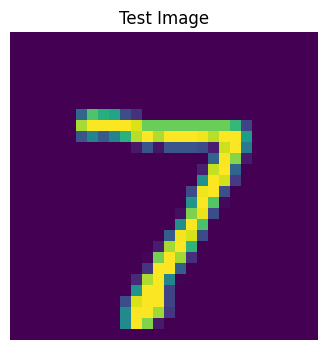

In [8]:
plt.figure(figsize=(4, 4))
plt.title("Test Image")
plt.imshow(test_images[0].squeeze())
plt.axis("off")

(-0.5, 27.5, 27.5, -0.5)

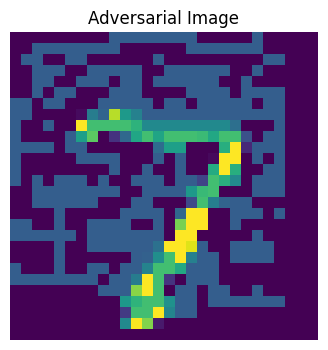

In [9]:
plt.figure(figsize=(4, 4))
plt.title("Adversarial Image")
plt.imshow(test_images_adv[0].squeeze())
plt.axis("off")

## Evaluate the attack

In [10]:
score_clean = model.evaluate(test_images, test_labels)
score_adv = model.evaluate(test_images_adv, test_labels)

313/313 [==============================] - 0s 2ms/step - loss: 6.5219 - accuracy: 0.0600


In [11]:
print("Clean accuracy: ", score_clean[1])
print("Adversarial accuracy: ", score_adv[1])

Clean accuracy:  0.9876999855041504
Adversarial accuracy:  0.05999999865889549


## Test the accuracy of the model with different attacks strengths

1/1 [==============================] - 0s 10ms/step


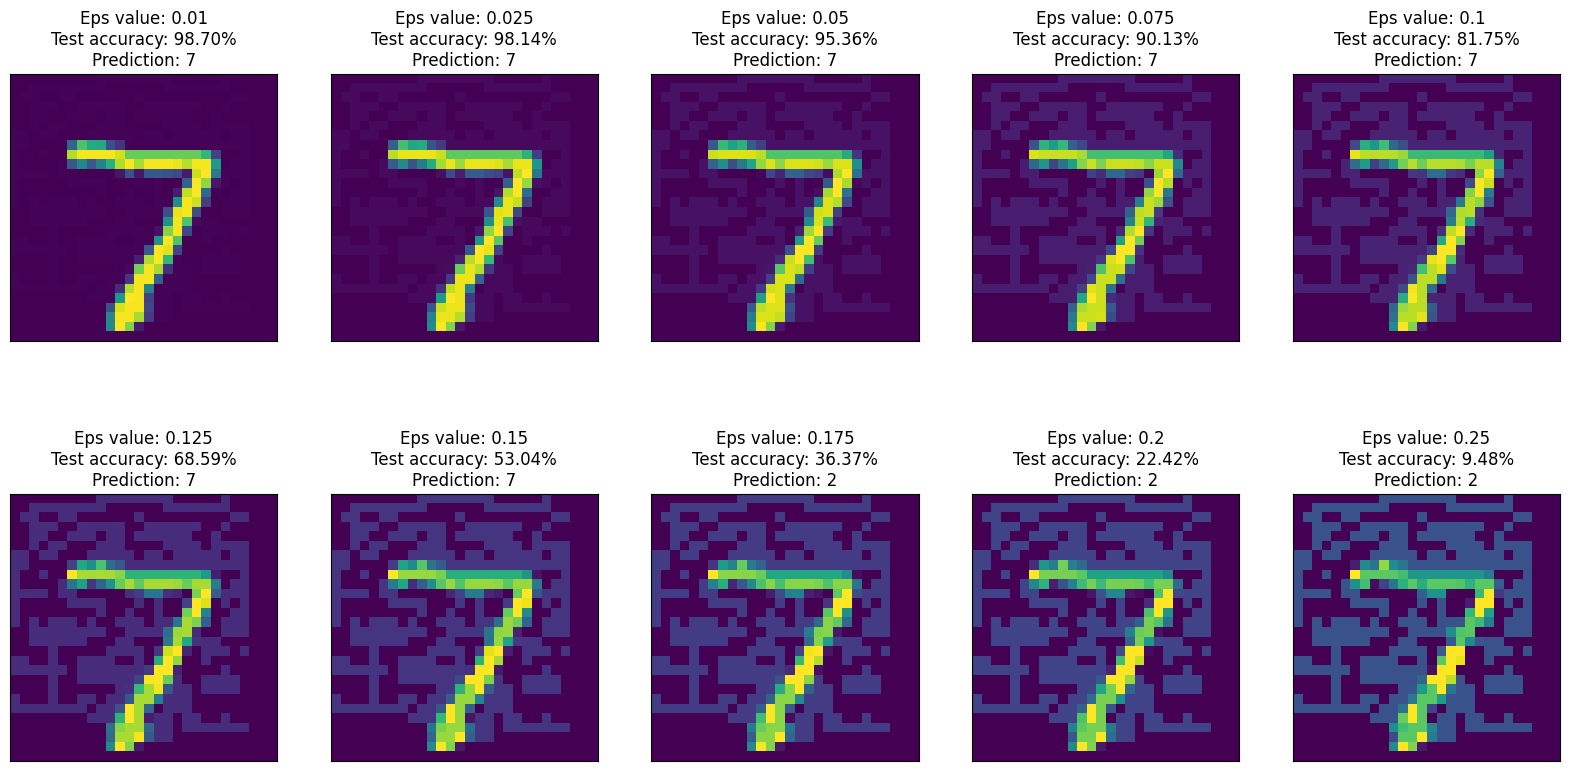

In [12]:
# Setting the number of rows and columns for the figure
nrows, ncols = 2, 5

# Generating subplots
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20, 10)
)

# Defining a range of eps values to try
eps_to_try = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.25]

# Defining a counting variable to traverse eps_to_try
counter = 0

# Iterating over rows and cols
for i in range(nrows):
    for j in range(ncols):
        # Creating an attack object for the current value of eps
        attack = FastGradientMethod(
            estimator=classifier,
            eps=eps_to_try[counter]
        )

        # Generating adversarial images
        test_images_adv = attack.generate(x=test_images)

        # Showing the first adversarial image
        axes[i, j].imshow(X=test_images_adv[0].squeeze())

        # Disabling x and y ticks
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])

        # Evaluating model performance on adversarial samples and retrieving test accuracy
        test_score = classifier._model.evaluate(
            x=test_images_adv,
            y=test_labels,
        )[1]

        # Getting prediction for the image that we displayed
        prediction = np.argmax(model.predict(
            x=np.expand_dims(a=test_images_adv[0],
                             axis=0)
        ))

        # Showing the current eps value, test accuracy, and prediction
        axes[i, j].set_title(
            label=f"Eps value: {eps_to_try[counter]}\n"
            f"Test accuracy: {test_score * 100:.2f}%\n"
            f"Prediction: {prediction}"
        )

        # Incrementing counter
        counter += 1

# Showing the plot
plt.show()